In [6]:
import os
import cv2
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import rasterio as rs
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, 
    BatchNormalization, Dropout, Lambda, Activation, MaxPool2D, Concatenate,
    RandomContrast
)

In [7]:
IMG_HEIGHT = 64
IMG_WIDTH = IMG_HEIGHT
IMG_CHANNELS = 2

In [8]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)

    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape):
    inputs = Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)  # Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation='sigmoid')(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

my_unet = build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
my_unet.compile(optimizer=Adam(learning_rate=1e-4),  loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
# Defina o diretório onde os arquivos foram salvos

path = "/home/cristiano/Imagens/"
# path = "/home/emanoelcepr/Imagens/"


diretorio_imagens = path + "imagens_originais/Sentinel-2/teste_processadas/"

# Caminhos completos para os arquivos X_test.npy 
X_test_file = os.path.join(diretorio_imagens, 'X_test.npy')
Y_test_file = os.path.join(diretorio_imagens, 'Y_test.npy')
Z_test_file = os.path.join(diretorio_imagens, 'Z_test.npy')


# Carregar os dados de volta para o notebook
X_test = np.load(X_test_file)
Y_test = np.load(Y_test_file)
Z_test = np.load(Z_test_file)


# Verificar a forma (shape) das arrays carregadas
print('Shape de X_train:', X_test.shape)
print('Shape de Y_train:', Y_test.shape)
print('Shape de Z_train:', Z_test.shape)


Shape de X_train: (1288, 64, 64, 2)
Shape de Y_train: (1288, 64, 64, 1)
Shape de Z_train: (1288, 64, 64, 3)


In [10]:
# use the best epoch
# my_unet.load_weights("/home/cristiano/Imagens/imagens_originais/Sentinel-2/treino_processadas/model70-30.h5")
my_unet.load_weights("/home/emanoelcepr/Imagens/imagens_originais/Sentinel-2/treino_processadas/model70-30.h5")
test_preds = my_unet.predict(X_test)

# Threshold the predictions

preds_test_thresh = (test_preds >= 0.5).astype(np.uint8)
preds_test_thresh = preds_test_thresh.reshape((len(X_test), IMG_WIDTH, IMG_HEIGHT, 1))

41/41 [==============================] - 18s 436ms/step


In [11]:
print("Evaluate on test data")
results = my_unet.evaluate(X_test, Y_test)
print("test loss: ", results)

Evaluate on test data
41/41 [==============================] - 19s 446ms/step - loss: 25.0080 - accuracy: 0.6098
test loss:  [25.008028030395508, 0.6097753047943115]


In [12]:
"""IOU"""

mean_iou1 = tf.keras.metrics.MeanIoU(num_classes=2)
mean_iou1.update_state(Y_test, preds_test_thresh, sample_weight=None)
iou = mean_iou1.result().numpy()
print("IOU: ", iou)

IOU:  0.30504614


In [13]:
"""Accuracy"""

acc1 = tf.keras.metrics.Accuracy()
acc1.update_state(Y_test, preds_test_thresh)
acc = acc1.result().numpy()
print("acurácia: ", acc)

acurácia:  0.6097753


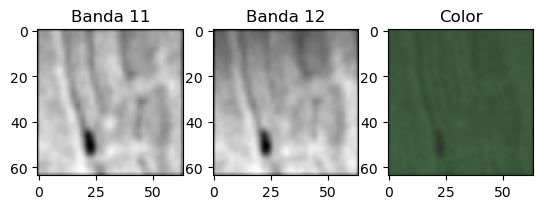

In [14]:
import matplotlib.pyplot as plt

# Selecionar a primeira amostra da array X_test, que contém a imagem composta pelas duas bandas
bandas = X_test[9]
color = Z_test[9]

# Separar as bandas individuais (assumindo que as bandas estão na última dimensão)
banda11 = bandas[:, :, 0]
banda12 = bandas[:, :, 1]

# Plotar as bandas individualmente
plt.subplot(1, 3, 1)
plt.imshow(banda11, cmap='gray')
plt.title('Banda 11')

plt.subplot(1, 3, 2)
plt.imshow(banda12, cmap='gray')
plt.title('Banda 12')

plt.subplot(1, 3, 3)
color_normalized = color / 255.0
plt.imshow(color_normalized)
plt.title('Color')


plt.show()

In [15]:
# Função para calcular a área total representada pelos pixels "true" na imagem "Segmentação Predita"
def calcular_area_total(img_pred):
    # Área de cada pixel (em metros quadrados)
    area_por_pixel_m2 = 10

    # Obter os índices dos pixels com valor 1
    indices_pixels_1 = np.argwhere(img_pred == 1)

    # Se houver algum pixel com valor 1
    if len(indices_pixels_1) > 0:
        # Obter a posição do primeiro pixel com valor 1 (linha e coluna)
        linha_primeiro_pixel_1, coluna_primeiro_pixel_1 = indices_pixels_1[0]

        # Contar a quantidade de pixels "true" na imagem (valor 1 na matriz)
        num_true_pixels = len(indices_pixels_1)

        # Calcular a área total (área por pixel multiplicada pelo número de pixels "true")
        area_total_m2 = num_true_pixels * area_por_pixel_m2

        # Retornar a área total e a posição do primeiro pixel encontrado
        return area_total_m2, (linha_primeiro_pixel_1, coluna_primeiro_pixel_1)
    else:
        print("Nenhum pixel com valor 1 encontrado na matriz.")
        return 0, None


In [16]:
def encontrar_latitude_longitude_por_posicao(id_imagem, linha, coluna):
    # Carregar o arquivo "informacoes_pixels_true.csv" em um DataFrame
    # df_informacoes = pd.read_csv("/home/cristiano/Imagens/imagens_originais/Sentinel-2/teste_processadas/metadados.csv")
    df_informacoes = pd.read_csv("/home/emanoelcepr/Imagens/imagens_originais/Sentinel-2/teste_processadas/metadados.csv")

    # Filtrar o DataFrame para encontrar a linha correspondente ao ID da imagem, linha e coluna
    filtro = (df_informacoes["ID_Imagem"] == id_imagem) & (df_informacoes["Linha"] == linha) & (df_informacoes["Coluna"] == coluna)
    df_filtrado = df_informacoes[filtro]

    # Verificar se algum registro foi encontrado
    if len(df_filtrado) > 0:
        # Obter a latitude e longitude do primeiro registro encontrado
        latitude = df_filtrado.iloc[0]["Latitude"]
        longitude = df_filtrado.iloc[0]["Longitude"]
        return latitude, longitude
    else:
        print(f"Nenhum registro encontrado para a imagem {id_imagem}, linha {linha}, coluna {coluna}.")
        return None, None


In [17]:
#Teste retorno lat e long
id_imagem = 2
linha = 190
coluna = 197

latitude, longitude = encontrar_latitude_longitude_por_posicao(id_imagem, linha, coluna)

if latitude is not None and longitude is not None:
    print(f"Latitude: {latitude}, Longitude: {longitude}")
else:
    print("Latitude e Longitude não encontradas.")


Nenhum registro encontrado para a imagem 2, linha 190, coluna 197.
Latitude e Longitude não encontradas.


Nenhum pixel com valor 1 encontrado na matriz.


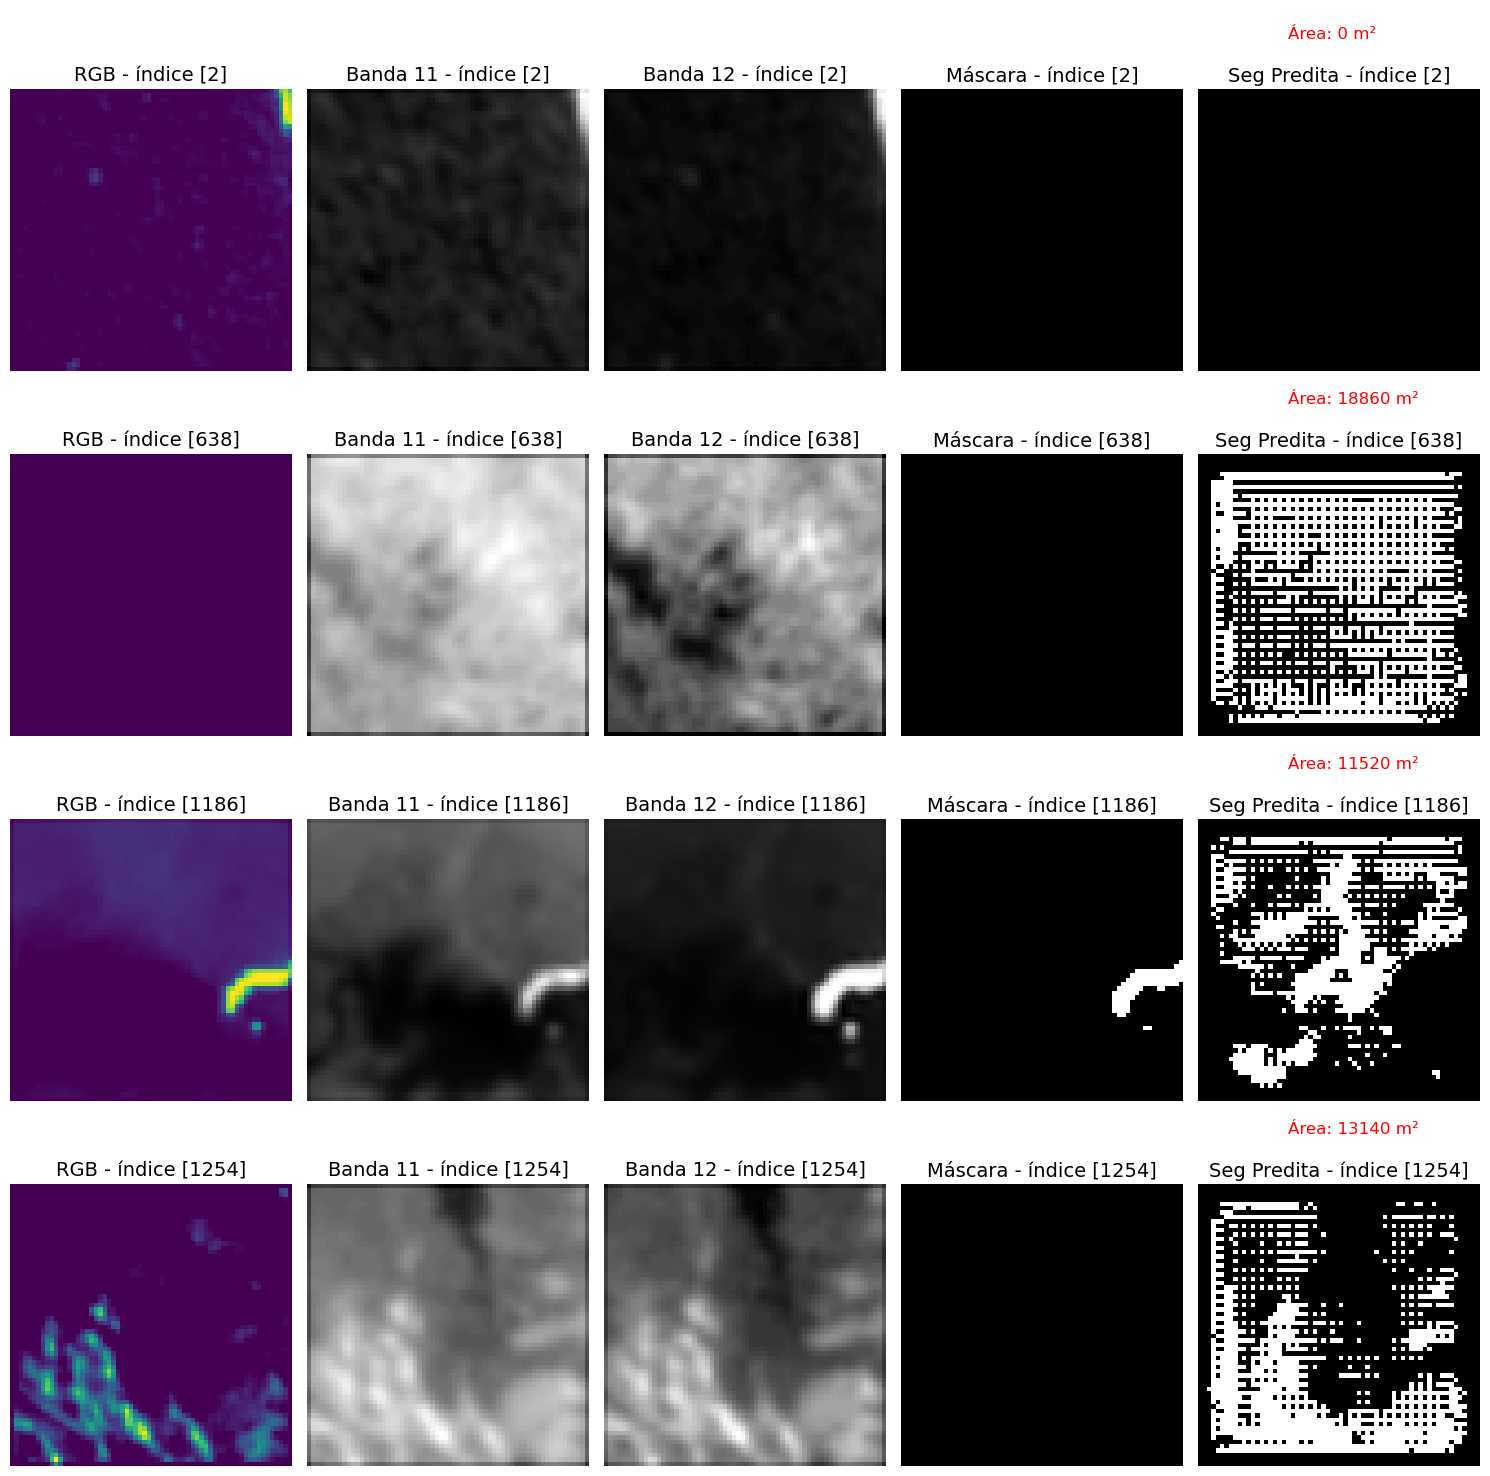

In [20]:
def plot_resultado(quantidade=4, random=14):
    # indices = df_test.sample(quantidade, random_state=random).index.values
    indices = [2, 638, 1186, 1254]
    plt.figure(figsize=(15, 15))
    j = 1
    for i in range(quantidade):
        rgb = Z_test[indices[i], :, :, 0].reshape((IMG_HEIGHT, IMG_WIDTH))
        b1 = X_test[indices[i], :, :, 0].reshape((IMG_HEIGHT, IMG_WIDTH))
        b2 = X_test[indices[i], :, :, 1].reshape((IMG_HEIGHT, IMG_WIDTH))
        seg = Y_test.reshape((-1, IMG_HEIGHT, IMG_WIDTH))[indices[i]]
        img_pred = preds_test_thresh[indices[i]].reshape((IMG_HEIGHT, IMG_WIDTH))

        imgs = [b1, b2, seg]
        
        plt.subplot(quantidade, 5, j)
        plt.imshow(rgb)
        plt.title('RGB - índice [' + str(indices[i]) + ']', fontsize=14)
        plt.axis('off')
        j += 1

        for img, nome in zip(imgs, ['Banda 11', 'Banda 12', 'Máscara']):
            plt.subplot(quantidade, 5, j)
            plt.imshow(img, cmap='gray')
            plt.title(f"{nome} - índice [{indices[i]}]", fontsize=14)
            plt.axis('off')
            j += 1

        # Calcular a área total representada pelos pixels "true" na imagem "Segmentação Predita"
        area_total_m2 = calcular_area_total(img_pred)
        
        #encontrar a latitude e longitude para a imagem de ID
        # latitude, longitude = encontrar_latitude_longitude_por_posicao(indices[i], area_total_m2[1][0], area_total_m2[1][1])

        # Adicionar o valor da área abaixo da label "Segmentação Predita"
        plt.subplot(quantidade, 5, j)
        plt.imshow(img_pred, cmap='gray')
        plt.title(f"Seg Predita - índice [{indices[i]}]", fontsize=14)
        plt.text(20, -15, f"\nÁrea: {area_total_m2[0]} m²", ha='left', va='center', fontsize=12, color='red')
        plt.axis('off')
        j += 1

    plt.tight_layout()
    plt.show()

# Substitua Z_test, X_test, Y_test e preds_test_thresh pelas matrizes adequadas.
plot_resultado()
